<a href="https://colab.research.google.com/github/aballiet/RL-LunarLander-v2/blob/master/RL_Double_DQN_LunarLander_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Q-Learning approach for LunarLander-v2

In [1]:
!apt install swig cmake libopenmpi-dev zlib1g-dev
!pip install stable-baselines==2.5.1 box2d box2d-kengz
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

Reading package lists... Done
Building dependency tree       
Reading state information... Done
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
libopenmpi-dev is already the newest version (2.1.1-8).
swig is already the newest version (3.0.12-1).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [0]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import csv
import random
import numpy as np
import math
import os
import glob
import io
import base64

from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

In [0]:
class DQAgent():
    def __init__(self, env, learning_rate, gamma, epsilon, epsilon_decay, batch_size):
        self.env = env

        self.state_size = 8
        self.nb_actions = 4

        # hyperparameter
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = 0.01
 
        # history variables
        self.history_length = 500000
        self.history = [[]for i in range(self.history_length)]
        self.history_idx = 0

        # rewards records
        self.rewards_list = []

        self.count = 0

        #Create and initialize the online DQN
        self.DQN_online = tf.keras.models.Sequential([
            Dense(512, activation='relu'),
            Dense(256, activation='relu'),
            Dense(self.nb_actions, activation='linear') #Outputs positive values
        ])
        self.DQN_online.build(input_shape=(None, self.state_size)) #Build the model to create the weights
        self.DQN_online.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(self.learning_rate))

        #Create and initialize the offline DQN
        self.DQN_offline = tf.keras.models.Sequential([
            Dense(512, activation='relu'),
            Dense(256, activation='relu'),
            Dense(self.nb_actions, activation='linear') #Outputs positive values
        ])
        self.DQN_offline.build(input_shape=(None, self.state_size)) #Build the model to create the weights

        self.copy_parameters() #Copy the weights of the online network to the offline network

    def copy_parameters(self):
        """Copy the parameters of the online network to the offline network"""
        weights = self.DQN_online.get_weights()
        self.DQN_offline.set_weights(weights)

    def insert_history(self, state, action, reward, new_state, done):
        """Insert experience in circular buffer history"""
        self.history[self.history_idx] = [state, action, reward, new_state, done] # Insert everything in the history
        self.history_idx = (self.history_idx+1)%self.history_length # Move the history_idx by one'''

    def learn(self):
        """Sample experiences from the history and performs SGD"""

        # check if we have more samples in history than requested batch_size
        if (self.count < self.batch_size):
            return

        # Samples random experiences from the history
        # (the more experiences we have, the more the distribution tend to an i.i.d distribution)
        bounds = min(self.count, len(self.history))
        idx = np.random.choice(range(bounds), self.batch_size, replace=False) # Create random indexes 
        rdm_exp =  [self.history[i] for i in idx] # Take experiences corresponding to the random indexes

        # Create 6 batches : states_vec, actions, rewards, new states_vec, end_boolean
        states_vec = np.array([rdm_exp[i][0] for i in range(self.batch_size)]) # Shape : [Bs, 8]
        actions = np.array([rdm_exp[i][1] for i in range(self.batch_size)]) # Shape : [BS]
        rewards = np.array([rdm_exp[i][2] for i in range(self.batch_size)]) # Shape : [BS]
        new_states_vec = np.array([rdm_exp[i][3] for i in range(self.batch_size)]) # Shape : [Bs, 8]
        end_boolean = np.array([rdm_exp[i][4] for i in range(self.batch_size)]) # Shape : [BS]

        #Forward pass through the online network to predict the q_values
        pred_q_values = self.DQN_online(new_states_vec)

        # compute targets
        targets = rewards + self.gamma * (np.amax(pred_q_values, axis=1)) * (1 - end_boolean)

        target_vec = self.DQN_offline(states_vec)
        target_vec = target_vec.numpy()

        indexes = np.array([i for i in range(self.batch_size)])
        target_vec[[indexes], [actions]] = targets

        self.DQN_online.fit(states_vec, target_vec, epochs=1, verbose=0)

    def get_action_from_greedy_agent(self, state):
        """Return action from model and with proba epsilon, return a random one"""
        if np.random.rand() < self.epsilon:
            return np.random.randint(low=0, high=self.nb_actions)
        
        state = np.reshape(state, [1, self.state_size])
        actions = self.DQN_online(state).numpy()

        return np.argmax(actions)

    def train(self, nb_episodes=20, num_steps = 1000, render=False):
        """Train DQN by performaing nb_episodes landing"""

        for i in range(nb_episodes):
            # Rest simulation before retrying landing
            state = self.env.reset()

            reward_acc = 0

            for j in range(num_steps):

                # get ation from greedy agent 
                action = self.get_action_from_greedy_agent(state)
                
                next_state, reward, done, info = self.env.step(action) # take a random action

                # accumulate rewards
                reward_acc += reward

                self.insert_history(state, action, reward, next_state, done)
                state = next_state # store new state
                self.count += 1

                # train once per 5 iterations
                if self.count%5 == 0:
                  self.learn()

                if done:
                  print('Episode {0} : {1} '.format(i, reward_acc))
                  self.rewards_list.append(reward_acc)
                  break
            
            self.copy_parameters() #Copy the weights of the online network to the offline network
            
            if (i%50 == 0):
              tf.keras.models.save_model(
              self.DQN_online, 'third'+str(i)+'.keras', overwrite=True, include_optimizer=True, save_format=None,
              signatures=None, options=None
              )

            if (i > 10 and np.min(self.rewards_list[-10:-1]) > 180):
              print('Training finished, average mean {0}'.format(np.mean(self.rewards_list[-10:-1])))
              tf.keras.models.save_model(
              self.DQN_online, 'third'+str(i)+'_final.keras', overwrite=True, include_optimizer=True, save_format=None,
              signatures=None, options=None
              )
              return

            # Decay the epsilon after each experience completion
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

In [5]:
print('Running Experiment...')
env = gym.make('LunarLander-v2')

learning_rate = 0.001
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995

batch_size = 64

agent = DQAgent(env, learning_rate, gamma, epsilon, epsilon_decay, batch_size)
agent.train(nb_episodes=600)

Running Experiment...
Episode 0 : -407.42952272414664 
Episode 1 : -172.26715069393407 
Episode 2 : -403.0659830513155 
Episode 3 : -153.97966522617148 
Episode 4 : -89.11096489157202 
Episode 5 : -257.64867671516924 
Episode 6 : -138.02442229187534 
Episode 7 : -154.92612582492492 
Episode 8 : -455.7178078602056 
Episode 9 : -64.56429260521247 
Episode 10 : -27.723452254133846 
Episode 11 : -104.40258490284953 
Episode 12 : -111.28779334865136 
Episode 13 : -310.04087967931287 
Episode 14 : -121.91124876530178 
Episode 15 : -180.60092238551886 
Episode 16 : -93.54505346379574 
Episode 17 : -389.9845536730923 
Episode 18 : -56.1691275997924 
Episode 19 : -236.73889196867847 
Episode 20 : 41.668685194186196 
Episode 21 : -122.02585940084589 
Episode 22 : -164.3740096398733 
Episode 23 : -220.49228815863114 
Episode 24 : -423.5381443208022 
Episode 25 : -184.20367998188894 
Episode 26 : -81.31712032988705 
Episode 27 : -84.1060134448962 
Episode 28 : -120.05825305728398 
Episode 29 : -28

In [0]:
with open("rewards.csv", 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(agent.rewards_list)

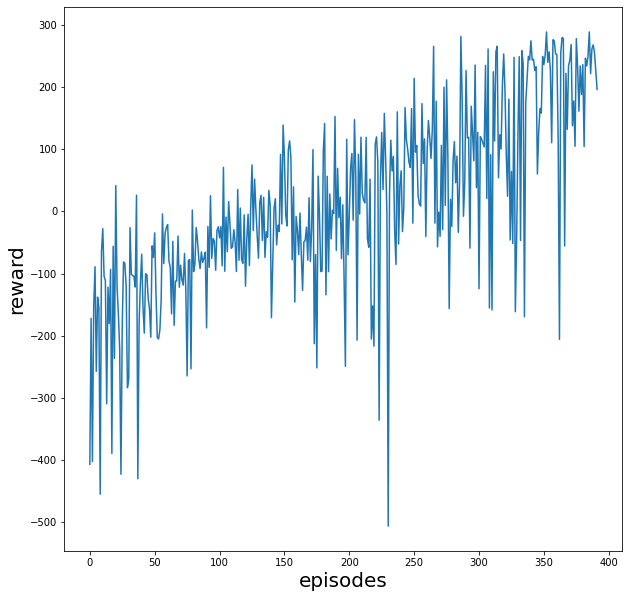

<Figure size 432x288 with 0 Axes>

In [7]:
fig = plt.figure(1, figsize=(10, 10))
plt.plot(agent.rewards_list)
plt.xlabel('episodes', fontsize=20)
plt.ylabel('reward', fontsize=20)
plt.show()
plt.savefig('plot.png')

In [3]:
display = Display(visible=0, size=(1400, 900))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1005'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1005'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [0]:
def get_action_from_greedy_agent(model, state, epsilon):
    """Return action from model and with proba epsilon, return a random one"""
    if np.random.rand() < epsilon:
        return np.random.randint(low=0, high=4)
    
    state = np.reshape(state, [1, 8])
    actions = model(state).numpy()

    return np.argmax(actions)

In [13]:
env = wrap_env(gym.make("LunarLander-v2"))

model = tf.keras.models.load_model('third391_final.keras')

state = env.reset()  

while True:
    env.render()
    action = get_action_from_greedy_agent(model, state, 0.02)
    next_state, reward, done, info = env.step(action)
    state = next_state # store new state

    if done: 
      break;
      
env.close()
show_video()

In [0]:
# Compare models
def testModel(name, nb_episodes):
  model = tf.keras.models.load_model(name)

  env = wrap_env(gym.make("LunarLander-v2"))

  result = []

  for i in range(nb_episodes):
    state = env.reset()  
    reward_acc = 0

    for i in range(1000):
      action = get_action_from_greedy_agent(model, state, 0.01) # get best action from model
      next_state, reward, done, info = env.step(action) # apply action in env
      reward_acc += reward # accumulate rewards
      state = next_state # store new state

      if done:
        break
    
    result.append(reward_acc)
  
  return result

In [7]:
# retrieve all keras models and compute rewards running 100 episodes
results = {}
for file in os.listdir('.'):
  if 'keras' in file:
    results[file] = testModel(file, nb_episodes=100)
    print('model {0} tested with average reward {1}'.format(file, np.mean(results[file])))

model third200.keras tested with average reward 10.61483895732702
model third350.keras tested with average reward 97.73411026487571
model third300.keras tested with average reward 151.0888597747293
model third391_final.keras tested with average reward 194.6608541273042
model third250.keras tested with average reward 112.78714780459443
model third150.keras tested with average reward -190.43338140483073
model third0.keras tested with average reward -489.1232133677165
model third100.keras tested with average reward 75.73436979361963
model third50.keras tested with average reward -98.31451357600385


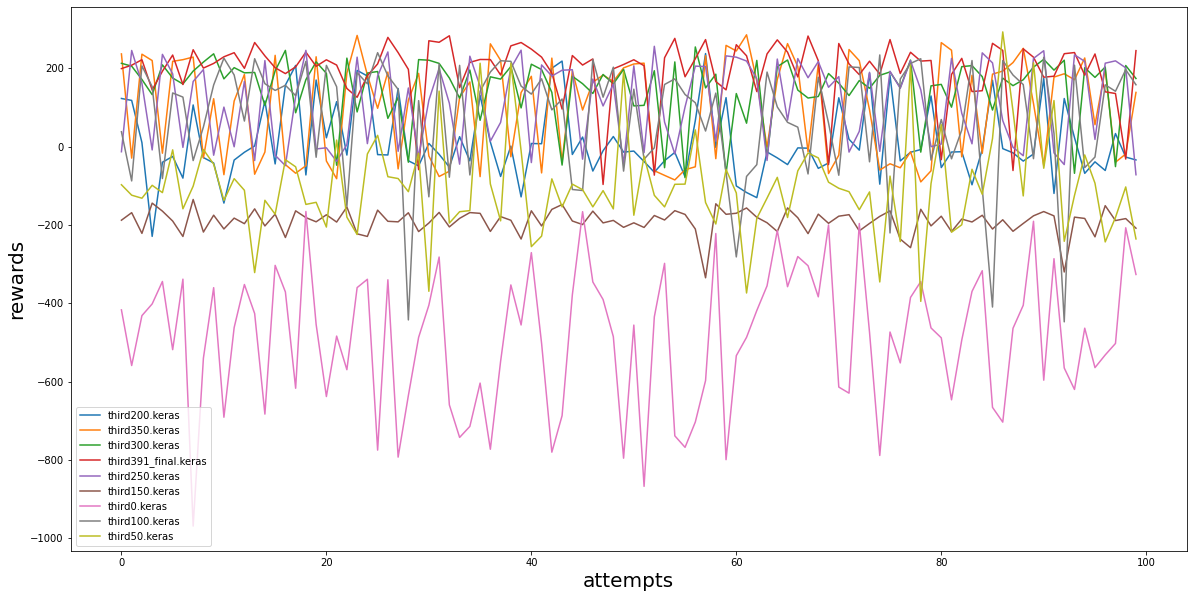

In [8]:
fig = plt.figure(1, figsize=(20, 10))
plt.xlabel('attempts', fontsize=20)
plt.ylabel('rewards', fontsize=20)

for key, value in results.items():
  plt.plot(value, label=key)
  plt.legend(key)

plt.legend(loc='lower left')
plt.show()